#**Neural Style Transfer**

Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

Based on: [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

Code references:
* https://www.tensorflow.org/tutorials/generative/style_transfer
* https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
* https://keras.io/examples/generative/neural_style_transfer


# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  
path = "drive/MyDrive/NST/"

Mounted at /content/drive


# Imports

In [ ]:
import torch  
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import requests
import copy

import numpy as np

# Use of gpu/cpu


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Images

Loading Transformer


In [ ]:
IMAGE_SIZE = 512 if device else 128

transformer = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  
    transforms.ToTensor()])  

Image Loader

In [ ]:
def image_loader(image_url, isurl = True):
    if isurl:
      image = Image.open(requests.get(image_url, stream=True).raw)
    else:
      image = Image.open(image_url)
    image = transformer(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg")
# style_img = image_loader('drive/MyDrive/NST/style/2.jpg', isurl = False)
content_img = image_loader("https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg")


In [ ]:
content_img.shape

torch.Size([1, 3, 512, 512])

In [ ]:
style_img.shape

torch.Size([1, 3, 512, 512])

In [ ]:
assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

Image Unloader

In [ ]:
transformer_unload = transforms.ToPILImage()  # reconvert into PIL image

def image_unloader(tensor_image):
    image = tensor_image.cpu().clone()  #Prevent changes in original tensor
    image = image.squeeze(0)      
    image = transformer_unload(image)
    plt.imshow(image)
    # return image


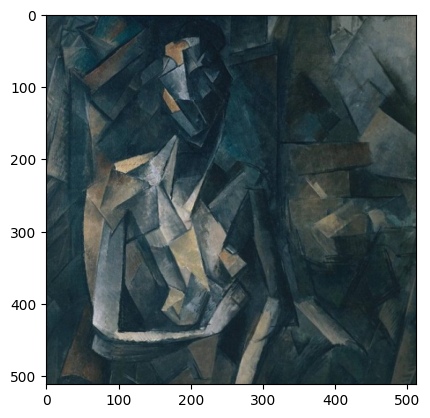

In [ ]:
image_unloader(style_img)

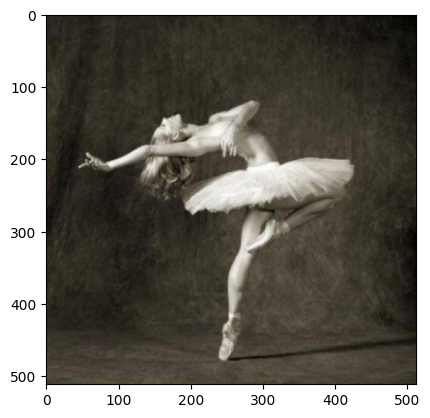

In [ ]:
image_unloader(content_img)

# Loss Functions

**Content Loss** 

Measures the difference between the feature maps of the input image and the content image at a selected layer of the VGG-19 network



> The paper mentions: 
 A layer with Nl distinct filters
has Nl feature maps each of size Ml
, where Ml
is the height times the width of the feature map.
So the responses in a layer l can be stored in a matrix F
l ∈ RNl×Ml where F
l
ij is the activation
of the i
th filter at position j in layer l.

>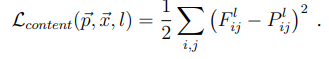


In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

**Gram Matrix** 

Used to capture the “distribution of features” of a set of feature maps

> The paper mentions: 
feature correlations are given by the
Gram matrix Gl ∈ RNl×Nl
, where Gl
ij is the inner product between the vectorised feature m

>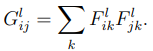

In [ ]:
def gram_matrix(input):
            a, b, c, d = input.size()  
            # [a, b, c, d] = [batch size, no. of feature maps, feature map dimension: c * d]
            features = input.view(a * b, c * d)  # resise feature map
            G = torch.mm(features, features.t())  # compute the gram product
            return G.div(a * b * c * d) # normalize gram matrix values

**Style Loss**

Measures the difference between the features of the input image and the style image
> The paper mentions: To generate a texture that matches the style of a given image (Fig 1, style reconstructions),
we use gradient descent from a white noise image to find another image that matches the style
representation of the original image. This is done by *minimising the mean-squared distance
between the entries of the Gram matrix from the original image and the Gram matrix of the
image to be generated.* So let ~a and ~x be the original image and the image that is generated and
Al
and Gl
their respective style representations in layer l

> 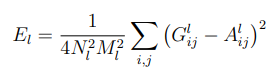

>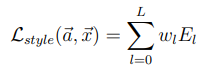

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Load CNN Network

**VGG Network**

VGG-19 is a trained Convolutional Neural Network, from Visual Geometry Group, Department of Engineering Science, University of Oxford. The number 19 stands for the number of layers with trainable weights. 16 Convolutional layers and 3 Fully Connected layers. It is widely used for image recognition and object detection.

>The paper mentions: a Convolutional Neural Network that rivals human performance on a common visual object
recognition benchmark task

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 198MB/s]


Why normalize?

https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel
RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

> https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg19_bn.html#torchvision.models.vgg19_bn

> "*Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]."*

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can directly work with image Tensor of shape [B x C x H x W].\
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std # normalize img

Architecture:
>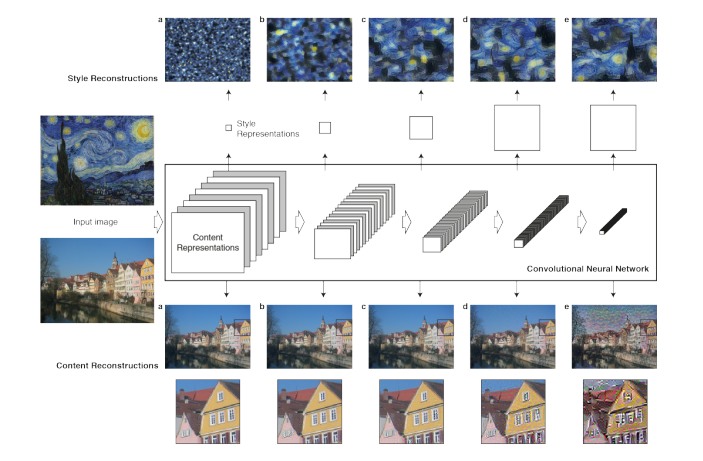

>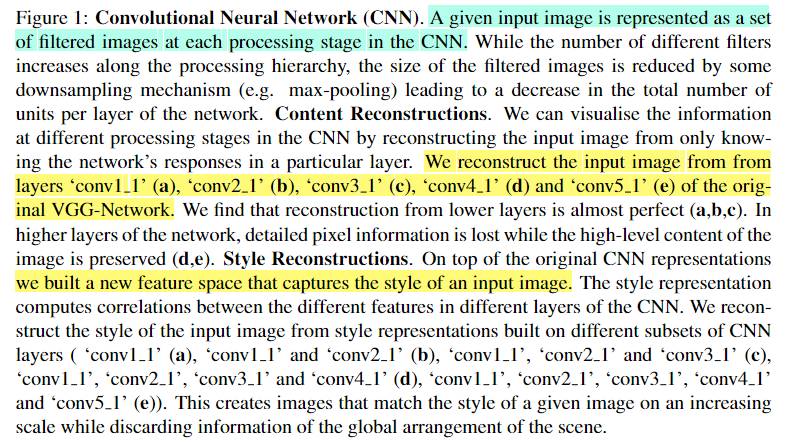

In [ ]:
# configure VGG layers

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  
    for layer in cnn.children(): 
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Intermediate layers for style and content:

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

source: https://www.tensorflow.org/tutorials/generative/style_transfer


Content and style weights experimentation: https://www.cs.princeton.edu/courses/archive/fall17/cos429/COS429-proj/COS429_neuralstyle_HaochenYuyan.pdf

In [ ]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

# Style Transfer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1000000, content_weight=1):
    
    print('---Building Model---')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    
    print(model.eval())

    # We want to optimize the input and not the model parameters so we update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('---Optimizing---')
    
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
                plt.figure()
                image_unloader(input_img)
                plt.show()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

*NOTES*

1. Clamping: 

  Clamps all elements in input into the range [ min, max ]
  https://pytorch.org/docs/stable/generated/torch.clamp.html

2. no_grad:

  Context-manager that disabled gradient calculation.

  Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.

  https://pytorch.org/docs/stable/generated/torch.no_grad.html?highlight=no_grad#torch.no_grad

3. optimizer.step:

  closure (Callable) – A closure that reevaluates the model and returns the loss. Optional for most optimizers.

  https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html

4. Calculate gradients: loss.backward()

  https://www.tutorialspoint.com/what-does-backward-do-in-pytorch

Display the style transferred image

TRIAL: 6 stages of running 500 epochs

---Building Model---


<ipython-input-16-41283a8aa9f4>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-16-41283a8aa9f4>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
---Optimizing---
run [100]:
Style Loss : 1.144285 Content Loss: 3.043141



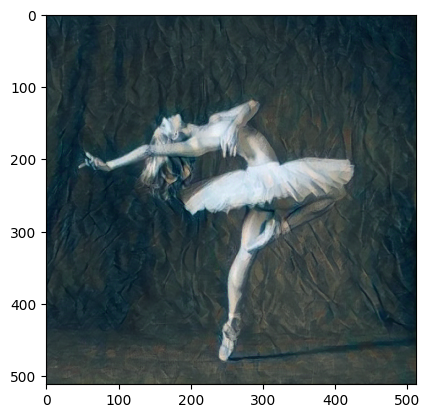

run [200]:
Style Loss : 0.472170 Content Loss: 2.498151



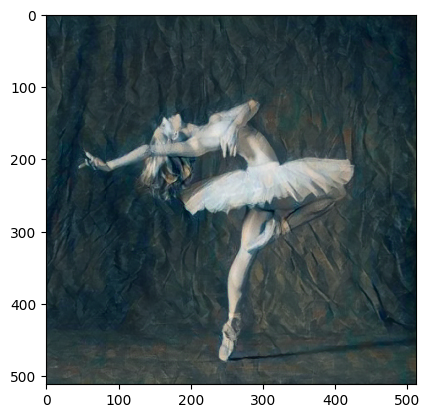

run [300]:
Style Loss : 0.263133 Content Loss: 2.359136



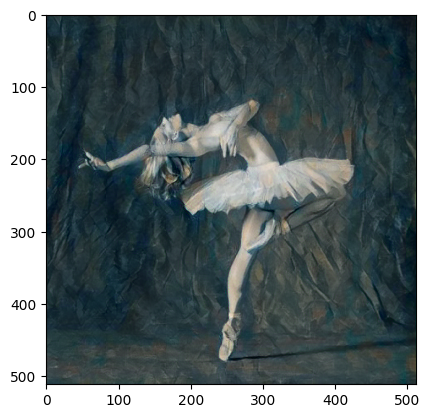

run [400]:
Style Loss : 0.183428 Content Loss: 2.298484



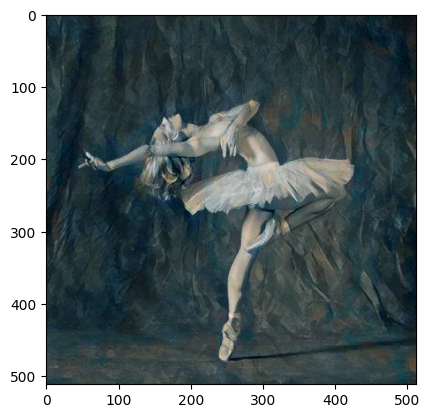

run [500]:
Style Loss : 0.155869 Content Loss: 2.262896



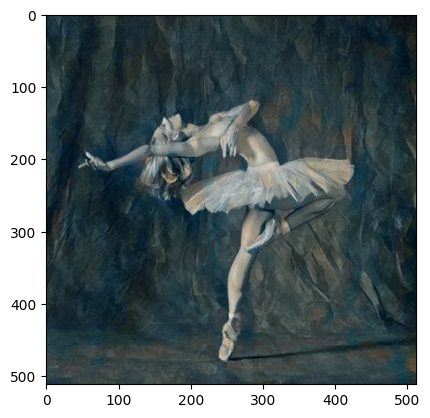

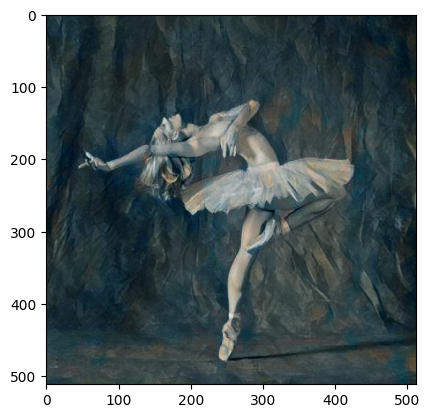

In [ ]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
image_unloader(output)
plt.show()

TRIAL: 1 content image - 50 styles

In [ ]:
def save_image(output, image_path):
    image_output = output[0].detach().cpu().numpy()
    image_output = np.transpose(image_output, (1, 2, 0))
    plt.imsave(image_path, image_output)

In [ ]:
from os import listdir

content_dir = 'drive/MyDrive/NST/content/'
contents = listdir(content_dir)

for content in contents:
    content_img = image_loader(content_dir + content, isurl = False)


style_dir = 'drive/MyDrive/NST/style/'
styles = listdir(style_dir)

for style in styles:
    style_name = style.split('.')[0]
    image_path = path + style_name + '.png'
    style_img = image_loader(style_dir + style, isurl = False)
    input_img = content_img.clone()
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
    save_image(output, image_path)

---Building Model---
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
---Optimizing---


<ipython-input-76-41283a8aa9f4>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-76-41283a8aa9f4>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 135.680222 Content Loss: 37.547569

run [100]:
Style Loss : 39.115692 Content Loss: 36.588554

run [150]:
Style Loss : 22.699894 Content Loss: 34.673294

run [200]:
Style Loss : 15.268755 Content Loss: 32.729370

run [250]:
Style Loss : 10.770178 Content Loss: 31.070412

run [300]:
Style Loss : 7.893715 Content Loss: 29.870749

---Building Model---
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_

TRIAL: 1 style - 5 content images - 300 epochs

In [ ]:
from os import listdir

content_dir = 'drive/MyDrive/NST/content/'
contents = listdir(content_dir)

# for content in contents:
#     content_img = image_loader(content_dir + content, isurl = False)


style_dir = 'drive/MyDrive/NST/style/'
styles = listdir(style_dir)

for style in styles:
    style_img = image_loader(style_dir + style, isurl = False)
    break

for content in contents:
    content_name = content.split('.')[0]
    image_path = path + content_name + '.png'
    content_img = image_loader(content_dir + content, isurl = False)
    input_img = content_img.clone()
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
    save_image(output, image_path)

---Building Model---
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
---Optimizing---


<ipython-input-76-41283a8aa9f4>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-76-41283a8aa9f4>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 122.886009 Content Loss: 37.601730

run [100]:
Style Loss : 39.463615 Content Loss: 36.674061

run [150]:
Style Loss : 22.616320 Content Loss: 34.668854

run [200]:
Style Loss : 15.289123 Content Loss: 32.746727

run [250]:
Style Loss : 10.805616 Content Loss: 31.063255

run [300]:
Style Loss : 7.834949 Content Loss: 29.755693

---Building Model---
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_

TRIAL: 1 style - 5 content images - 500 epochs


In [ ]:
from os import listdir

content_dir = 'drive/MyDrive/NST/content/'
contents = listdir(content_dir)

# for content in contents:
#     content_img = image_loader(content_dir + content, isurl = False)


style_dir = 'drive/MyDrive/NST/style/'
styles = listdir(style_dir)

for style in styles:
    style_img = image_loader(style_dir + style, isurl = False)
    break

for content in contents:
    content_name = content.split('.')[0]
    image_path = path + '500epchs/' + content_name + '.png'
    content_img = image_loader(content_dir + content, isurl = False)
    input_img = content_img.clone()
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
    save_image(output, image_path)

---Building Model---
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
---Optimizing---


<ipython-input-16-41283a8aa9f4>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-16-41283a8aa9f4>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [500]:
Style Loss : 4.459428 Content Loss: 27.356529

---Building Model---
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
---Optimizing---
run [500]:
Style Loss : 1.374307 Conten

TRIAL: 1 style - 5 content images - 800 epochs




In [ ]:
from os import listdir

content_dir = 'drive/MyDrive/NST/content/'
contents = listdir(content_dir)

# for content in contents:
#     content_img = image_loader(content_dir + content, isurl = False)


style_dir = 'drive/MyDrive/NST/style/'
styles = listdir(style_dir)

for style in styles:
    style_img = image_loader(style_dir + style, isurl = False)
    break

for content in contents:
    content_name = content.split('.')[0]
    image_path = path + '800/' + content_name + '.png'
    content_img = image_loader(content_dir + content, isurl = False)
    input_img = content_img.clone()
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
    save_image(output, image_path)

---Building Model---
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
---Optimizing---


<ipython-input-16-41283a8aa9f4>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-16-41283a8aa9f4>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [500]:
Style Loss : 2.952529 Content Loss: 27.364475

---Building Model---
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
---Optimizing---
run [500]:
Style Loss : 1.350869 Conten

# Cycle GAN

This is an implementation of unpaired image to image translation using conditional GAN's, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples.

References:


*   https://www.tensorflow.org/tutorials/generative/cyclegan
*   https://www.kaggle.com/code/songseungwon/cyclegan-tutorial-from-scratch-monet-to-photo




# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  
path = "drive/MyDrive/CycleGAN/"

Mounted at /content/drive


In [ ]:
!unzip -n -q "/content/drive/My Drive/CycleGAN/cycleGAN_dataset.zip" -d ""

# Imports

In [ ]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import os

# Use of gpu/cpu


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Settings

In [ ]:
# data 
dataset_path = './cycleGAN_dataset/'
img_height = 256
img_width = 256
channels = 3

# training
epoch = 0 # epoch to start training from
n_epochs = 5 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 3 # suggested default : 100 (suggested 'n_epochs' is 200) epoch from which to start lr decay

# Generator Network

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(input_features, input_features, 3),
            nn.InstanceNorm2d(input_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(input_features, input_features, 3),
            nn.InstanceNorm2d(input_features)
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(Generator, self).__init__()        
        channels = input_shape[0]
        
        # Initial Convolution Block
        output_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, output_features, 7),
            nn.InstanceNorm2d(output_features),
            nn.ReLU(inplace=True)
        ]
        input_features = output_features
        
        # Downsampling
        for _ in range(2):
            output_features *= 2
            model += [
                nn.Conv2d(input_features, output_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(output_features),
                nn.ReLU(inplace=True)
            ]
            input_features = output_features
        
        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(output_features)]
            
        # Upsampling
        for _ in range(2):
            output_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(input_features, output_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            input_features = output_features
            
        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(output_features, channels, 7),
                  nn.Tanh()
                 ]
        
        # Unpacking
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

# Discriminator Network

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_feature):
        super(Discriminator, self).__init__()        
        channels, height, width = input_feature
        
        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            # Returns downsampling layers of each discriminator block
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
    def forward(self, img):
        return self.model(img)

# Loss Functions

In [ ]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Configure GAN

In [ ]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = Generator(input_shape, n_residual_blocks)
G_BA = Generator(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

In [ ]:
if device == 'cuda':
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

  
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

# Optimizer

In [ ]:
import itertools
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

In [ ]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [ ]:
# n_epochs = 10
# epoch = 0
# decay_epoch = 5


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

# Image Transformation

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

# Dataset

In [ ]:
from torch.utils.data import Dataset
import glob
dataset_path = 'cycleGAN_dataset'

class ImageDataset(Dataset):
    def __init__(self, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            # self.files_A = sorted(os.listdir(dataset_path + '/monet_jpg/')[:250])
            self.files_A = sorted(glob.glob(os.path.join(dataset_path+'/monet_jpg')+'/*.*')[:250])
            self.files_B = sorted(glob.glob(os.path.join(dataset_path+'/photo_jpg')+'/*.*')[:250])
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(dataset_path+'/monet_jpg')+'/*.*')[250:])
            self.files_B = sorted(glob.glob(os.path.join(dataset_path+'/photo_jpg')+'/*.*')[250:301])

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])        
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        # if image_A.mode != 'RGB':
        #     image_A = to_rgb(image_A)
        # if image_B.mode != 'RGB':
        #     image_B = to_rgb(image_B)
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
            

In [ ]:
dataloader = DataLoader(
    ImageDataset(transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True,
    # num_workers=n_cpu # 3
)

val_dataloader = DataLoader(
    ImageDataset(transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    # num_workers=n_cpu
)

In [ ]:
dataloader.dataset.files_A[0]

'cycleGAN_dataset/monet_jpg/000c1e3bff.jpg'

# Display Sample Images

In [ ]:
Tensor = torch.cuda.FloatTensor if device == 'cuda' else torch.Tensor

In [ ]:
import matplotlib.pyplot as plt
def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].type(Tensor) # A : monet
    fake_B = G_AB(real_A).detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = G_BA(real_B).detach()
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show();

# Training

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

  0%|          | 0/250 [00:00<?, ?it/s]

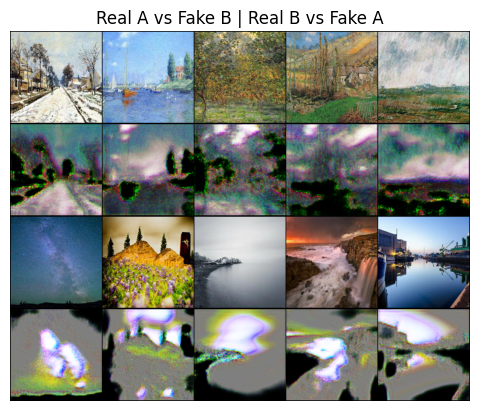

[Epoch 1/5] [Batch 50/250] [D loss : 0.461025] [G loss : 6.147783 - (adv : 0.577647, cycle : 0.374780, identity : 0.364467)]


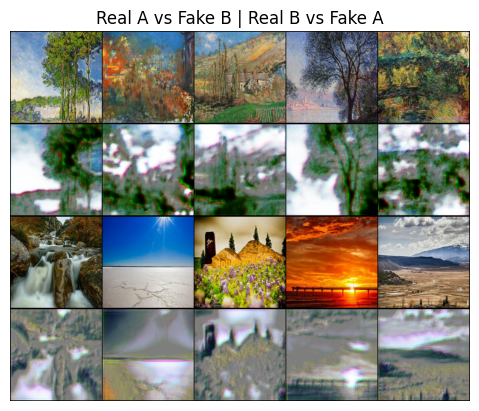

[Epoch 1/5] [Batch 100/250] [D loss : 0.272200] [G loss : 6.278683 - (adv : 0.336327, cycle : 0.399364, identity : 0.389743)]


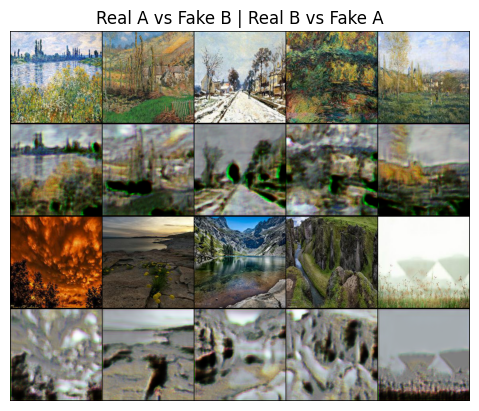

[Epoch 1/5] [Batch 150/250] [D loss : 0.299450] [G loss : 4.797864 - (adv : 0.643710, cycle : 0.287564, identity : 0.255703)]


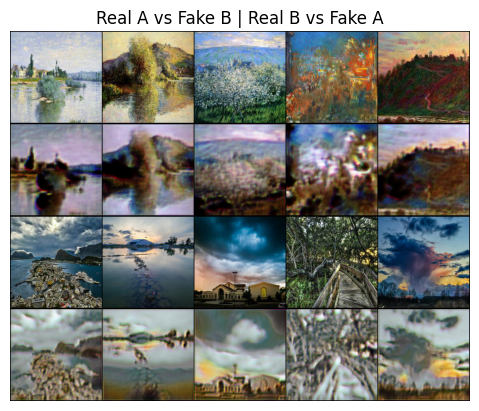

[Epoch 1/5] [Batch 200/250] [D loss : 0.183842] [G loss : 5.191873 - (adv : 0.429219, cycle : 0.321027, identity : 0.310477)]


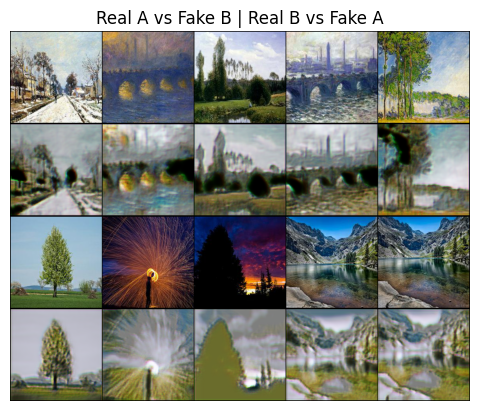

[Epoch 1/5] [Batch 250/250] [D loss : 0.259621] [G loss : 4.797197 - (adv : 0.391610, cycle : 0.299182, identity : 0.282753)]


  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        
        # Set model input
        real_A = batch['A'].type(Tensor)
        real_B = batch['B'].type(Tensor)
        
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        
# -----------------
# Train Generators
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss
        fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss
        recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        
# ------> Total Loss
        loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        
        loss_G.backward()
        optimizer_G.step()
        
# -----------------
# Train Discriminator A
# -----------------
        optimizer_D_A.zero_grad()
    
        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_A = (loss_real + loss_fake)/2
        
        loss_D_A.backward()
        optimizer_D_A.step()

# -----------------
# Train Discriminator B
# -----------------
        optimizer_D_B.zero_grad()
    
        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_B = (loss_real + loss_fake)/2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2
    
# -----------------
# Show Progress
# -----------------
        if (i+1) % 50 == 0:
            sample_images()
            print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                    %(epoch+1,n_epochs,       # [Epoch -]
                      i+1,len(dataloader),   # [Batch -]
                      loss_D.item(),       # [D loss -]
                      loss_G.item(),       # [G loss -]
                      loss_GAN.item(),     # [adv -]
                      loss_cycle.item(),   # [cycle -]
                      loss_identity.item(),# [identity -]
                     ))
